In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import sys
import math
import seaborn as sns

%matplotlib widget
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False #该语句解决图像中的“-”负号的乱码问题

Duplicate key in file PosixPath('/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 271 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


# 1. 数据处理

## 1.1 数据获取

目前有两种数据源：
- tke-x thanos
- 云梯 elasticsearch

目前离线评估数据使用 prom python 工具直接获取文件存 cos

## 1.2 数据 EDA

In [2]:
'''
Data clean function collection.
'''

# avoid not same namespace but same name
# max cpu usage less than 0.05 is dropped.
def choose_cpu_usage_column_name(df):
    columns = df.columns
    sequence = "cpu_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def load_csv_data(csv_path):
    raw = pd.read_csv(csv_path)
    df = pd.DataFrame(data=raw)
    return raw, df


def clean_data(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.owner_name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_result_dict={}
    max_less_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.owner_name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.owner_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_result_dict[namespaced_name] = seq_cpu_usage
    
    return needed_result_dict, max_less_dict
def choose_memory_usage_column_name(df):
    columns = df.columns
    sequence = "memory_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def clean_container_data_cpu_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_container_cpu_usage_dict={}
    max_less_container_cpu_usage_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
       
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
    return needed_container_cpu_usage_dict, max_less_container_cpu_usage_dict

def clean_container_data_memory_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    memory_usage_column_name = choose_memory_usage_column_name(df)
    needed_container_memory_usage_dict={}
    max_less_container_memory_usage_dict={}
    
    # delete max_memory_usage is too small data, 50m
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[memory_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[memory_usage_column_name]]
        seq_memory_usage = data_by_name[memory_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 10m
        seq_memory_usage[seq_memory_usage < 10] = 0
        # cpu_usage is too small 
        if data_by_name[memory_usage_column_name].max() < 50:
            max_less_container_memory_usage_dict[namespaced_name] = seq_memory_usage
            continue
        needed_container_memory_usage_dict[namespaced_name] = seq_memory_usage
    
    return needed_container_memory_usage_dict, max_less_container_memory_usage_dict

# TODO(summary from EDA notebook file.)

In [3]:
'''
Load application data for evaluatation.
'''
# from different cluster, all is 15 days data.
_,cpu_data_20220418_20220502_0a9obzx3 = load_csv_data("./dataset/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_data.csv")
_, cpu_metadata_20220418_20220502_0a9obzx3 =load_csv_data("./dataset/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_metadata.csv")
_, cpu_label_data_20220418_20220502_0a9obzx3 =load_csv_data("./dataset/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_label_data.csv")

_, cpu_data_20220425_20220509_4g9b5b18 = load_csv_data("./dataset/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_data.csv")
_, cpu_metadata_20220425_20220509_4g9b5b18 = load_csv_data("./dataset/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_metadata.csv")
_, cpu_label_data_20220425_20220509_4g9b5b18 = load_csv_data("./dataset/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_label_data.csv")

In [4]:
cpu_data_20220418_20220502_0a9obzx3
cpu_metadata_20220418_20220502_0a9obzx3
# cpu_label_data_20220418_20220502_0a9obzx3

,prometheus.labels.name,prometheus.labels.container_name,prometheus.labels.namespace,prometheus.query.pod_name,prometheus.labels.cluster,prometheus.labels.kubernetes_io_machine_type
0,5c6f227f72fcd3e8afa9bcecb750fcf39b29179672e0ec...,airport-container,ns-prj2n6w9-957095-production,hdmap-material-process-slave-prod-47,cls-0a9obzx3,NaN
1,bdcb18f3207e808034a406f7ddd0e07fa05a684555b549...,airport-container,ns-prj2n6w9-957095-production,hdmap-material-process-slave-prod-39,cls-0a9obzx3,NaN
2,f0bbceedc2a5e3b01ffb3458f3214d77d2b8199dfca4ec...,airport-container,ns-prj2n6w9-957095-production,hdmap-material-process-slave-prod-49,cls-0a9obzx3,NaN
3,141dc8fef7290f6836092124d7583e15432bf52ae6d863...,airport-container,ns-prj2n6w9-957095-production,hdmap-material-process-slave-prod-48,cls-0a9obzx3,NaN
4,b6d3b6971031908a0625191c218a5553d2513914850f93...,airport-container,ns-prj2n6w9-957095-production,hdmap-material-process-slave-prod-44,cls-0a9obzx3,NaN
...,...,...,...,...,...,...
78,ed4c3dd43c4365924f7f6d6f7907c7c5b1deb82b625c84...,trpc-oidb-production,ns-prjcmtjr-1288508-production,trpcoidbproduction-bj6-eks-32cpu-18,cls-0a9obzx3,NaN
79,8a9765d187d5d003db4dc384872a03e28ae4dd0fc0917a...,trpc-oidb-production,ns-prjcmtjr-1288508-production,trpcoidbproduction-bj6-eks-32cpu-13,cls-0a9obzx3,NaN
80,0db643fe18da9f0c61c915afcf23881264e7fc390b2301...,trpc-oidb-production,ns-prjcmtjr-1288508-production,trpcoidbproduction-bj6-eks-32cpu-27,cls-0a9obzx3,NaN
81,21fa5f3889edba780731baf86488f4d032521641502771...,trpc-oidb-production,ns-prjcmtjr-1288508-production,trpcoidbproduction-bj6-eks-32cpu-14,cls-0a9obzx3,NaN


In [5]:
# EDA can see other notebook file.

# 2. fft 判断是否是周期信号分类算法

In [111]:
'''
Crane v0.3.0 periodic check func.
'''
# crane v0.3.0 
# PredictorManager(realtimeDataSources,historyDataSource), default all is prom data source
# Default algrithm is dsp and percentile, for dsp model update interval default is 12h
# periodicSignalPrediction(DSP) Run 
    # goroutinue for loop to watch QueryExprWithCaller request channel
        # goroutinue updateAggregateSignalsWithQuery, include dsp/percentile config like sample internal, history length etc.
            # query history time series from history data source proxy
            # updateAggregateSignals
                # default history resolution 1 minutes, duration is 15d, resoultion can`t more 1 hour, duration can`t less 2d.
                # set estimator, max(need margin)、fft(margin、highFrequencyThreshold、lowAmplitudeThreshold、min/maxNumOfSpectrumItems)、
                # isPeriodicTimeSeries
                    # change samples to signals and set sample rate via history resolution
                        # sample rate is 1/resolution(s)
                    # isPeriodic
                        # history resolution while is signal length at least double of period
                        # get frequencies from signals via fft
                        # if cycle time(1/freq) less than period, is not periodic
                        # if cycle time almost equal(epsilon<1e-3), think it is periodic
                    
# crane dsp fft is_periodicity
from scipy.fft import fft  

# fft algorithm to check the signal is or not is periodic signal.
def is_periodicity(data, sample_interval, cycle_duration,show_pic=False):
    """
    :param data:  检测数据，ndarray 类型
    :param sample_interval: 采样数据的时间,单位 s
    :param cycle_duration: 预测周期,单位 s
    :param show_pic: 是否展示图片
    :return: is_cycle 为是否周期性, cycles 为可能的周期列表
    """
    is_cycle = False
    sample_rate = 1.0 / sample_interval
    n = int(cycle_duration * sample_rate)
    m = 0
    i = len(data)
    while (i-n >=0):
        i-=n
        m += 1
    data = data[i:]
    if m < 2 : return is_cycle, None
    sample_length = len(data)
    result = pd.DataFrame(columns=['amp', 'freq'])
    fft_y = fft(data)
    result['amp'] = np.abs(fft_y)/sample_length*2
    result['freq'] = sample_rate*np.arange(sample_length)/len(fft_y)
    length = int(len(result['freq'])/2)
    result = result[:][1:length]
    if show_pic is True:
        fig,axs = plt.subplots(1,2,figsize=(8,2),dpi=100)
        x=np.arange(sample_length -1)
        axs[0].plot(x,result['amp'])
        axs[0].set_title('幅值归一化')
        axs[1].plot(x,result['freq'])
        axs[1].set_title('频率')
        plt.show()
        
    # 按照幅值强弱程度降序排列
    result = result.sort_values(by='amp', ascending=False)
    # pd.options.display.float_format = '{:.2f}'.format
    # result.head()
    # 频率转换为周期
    cycle_list = 1 / result['freq'].values
    #print(cycle_list)
    is_cycle = False
    cycles = []
    for cycle in cycle_list:
        # 判断是不是整数
        if cycle > cycle_duration:
            return is_cycle, cycles  
        m = cycle_duration/cycle
        epsilon = abs(m - float(int(m)))
        # optimization： set hyper-parameter
        if epsilon < 1e-3:
            is_cycle = True
            cycles.append(cycle)
            return is_cycle, cycles
    return is_cycle, cycles

def test_is_periodicity(show_pic):
    epsilon = 1e-15
    frequency = 5 # hz
    sample_interval = 0.001 # 采样 0.001s
    sample_rate = 1.0/sample_interval # 采样频率 Hz
    
    x = np.arange(0.0,1.0,sample_interval,dtype=float)
    
    freqs = [frequency,frequency,frequency,frequency,frequency]
    growth_ratio = 0.1
    signals = [np.sin(freqs[0]*2*np.pi*x) + 1.0,
               np.sin(freqs[1]*2*np.pi*x+np.random.random_sample())+1.0,
               np.sin(2.0*freqs[2]*np.pi*x)+0.5*np.sin(2.0*freqs[2]*4*np.pi*x)+3.0,
               np.sin(2.0*freqs[3]*np.pi*x) + 2*np.random.random_sample(),
               (1.0+np.floor(x/(1/freqs[4])*growth_ratio))* np.sin(2.0*freqs[4]*np.pi*x)]
    
    for i in range(len(freqs)):
        y = signals[i]
        cycle_duration = 1.0/freqs[i] # s
        if show_pic is True:
            plt.plot(x,y)
            plt.show()
        is_cycle, cycles = is_periodicity(y, sample_interval, cycle_duration,show_pic=False)
        
        if not is_cycle:
            raise ValueError("test error")
        else:
            print("is cycle")
        
        if len(cycles) == 0:
            raise ValueError("no cycles error")
        print(cycles)
        assert (cycles[0]-cycle_duration < epsilon)
    return


In [109]:
test_is_periodicity(False)

is cycle
[0.2]
is cycle
[0.2]
is cycle
[0.2]
is cycle
[0.2]
is cycle
[0.2]


In [99]:
a = pd.read_csv("dataset/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_data.csv", index_col="name")

In [115]:
for i in range(a.shape[0]):
    data = a.iloc[i].values
    sample_interval = 60
    cycle_duration = 7*60*60*24
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    if len(cycles) > 0:
        print(i,":",is_cycle, ":",cycles[0]/60/60/24)
    else: 
         print(i,":",is_cycle, ":",cycles)

0 : True : 7.0
1 : False : []
2 : False : []
3 : False : []
4 : True : 7.0
5 : False : []
6 : False : []
7 : False : []
8 : False : []
9 : True : 7.0
10 : False : []
11 : False : []
12 : True : 7.0
13 : True : 7.0
14 : True : 7.0
15 : False : []
16 : False : []
17 : False : []
18 : True : 7.0
19 : False : []
20 : True : 7.0
21 : False : []
22 : False : []
23 : False : []
24 : True : 7.0
25 : True : 7.0
26 : True : 7.0
27 : True : 7.0
28 : False : []
29 : False : []
30 : False : []
31 : False : []
32 : True : 7.0
33 : False : []
34 : True : 7.0
35 : False : []
36 : False : []
37 : False : []
38 : False : []
39 : False : []
40 : False : []
41 : True : 7.0
42 : False : []
43 : False : []
44 : False : []
45 : False : []
46 : False : []
47 : False : []
48 : False : []
49 : False : []
50 : False : []
51 : True : 7.0
52 : False : []
53 : False : []
54 : False : []
55 : True : 7.0
56 : False : []
57 : False : []
58 : False : []
59 : True : 0.006944444444444444
60 : True : 0.006944444444444444


## 2.1 fft 分类算法验证 - crane test data

In [8]:
'''
load crane test data(16 samples)
'''

signal_cycle_labels = pd.DataFrame(columns=['is_cycle','cycle_duration'])
is_cycle = ['true','true','true','true','false','false','false','false','true','true','true','true','true','true','true','true']
cycle_duration = [60*60*24,60*60*24,60*60*24,60*60*24,0,0,0,0,60*60*24,60*60*24,60*60*24,60*60*24,60*60*24,60*60*24,60*60*24,60*60*8]
signal_cycle_labels['is_cycle'] = is_cycle
signal_cycle_labels['cycle_duration'] = cycle_duration
signal_cycle_labels.iloc[0]["is_cycle"]
len(signal_cycle_labels)

16

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


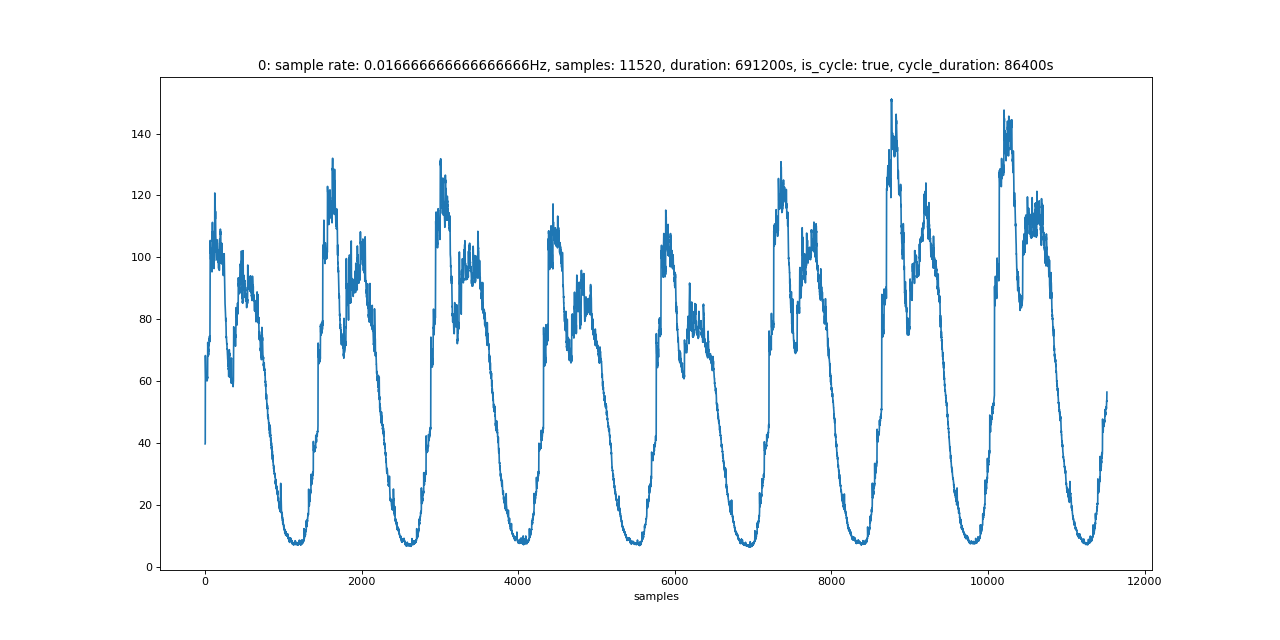

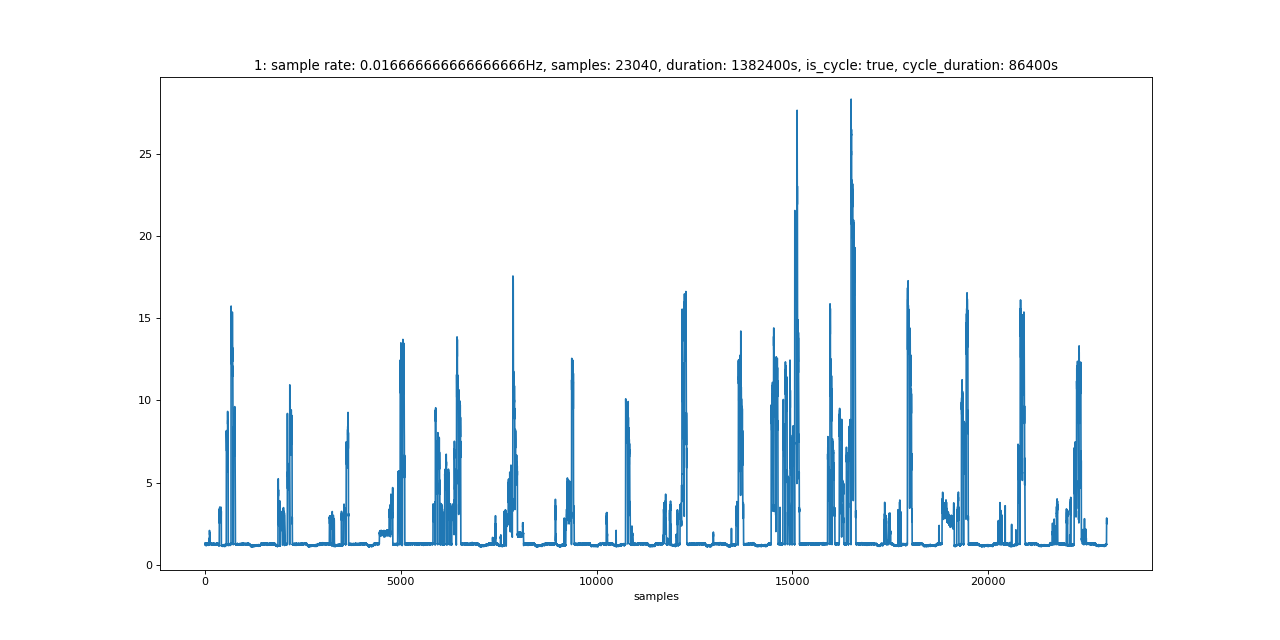

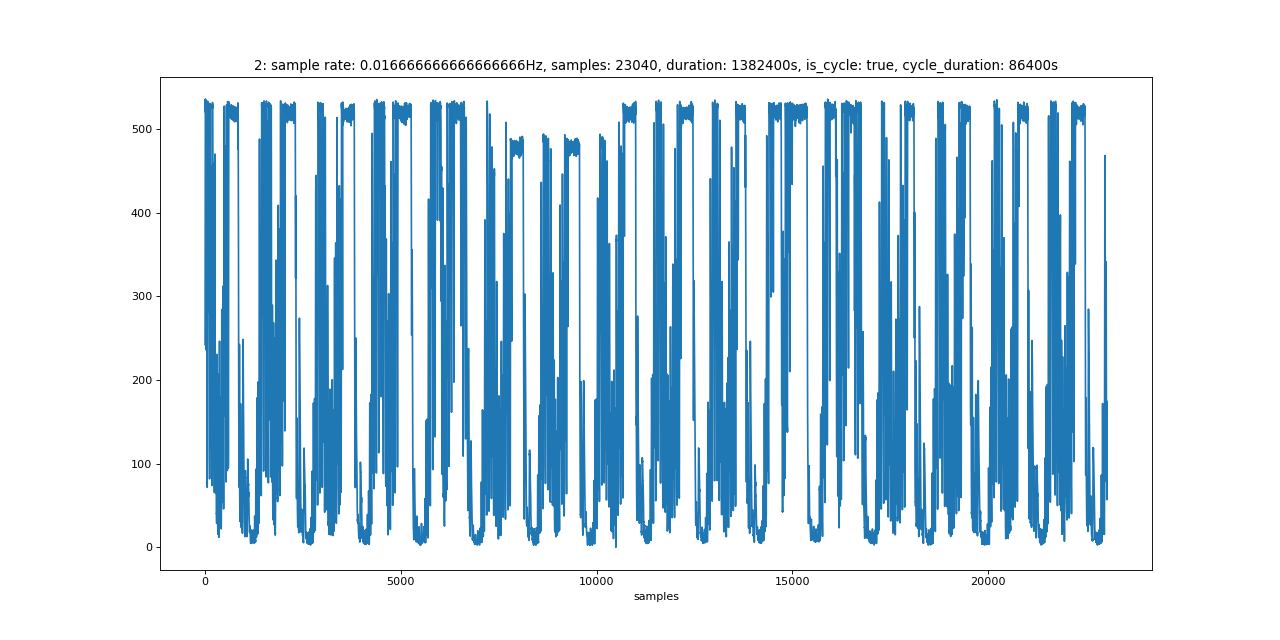

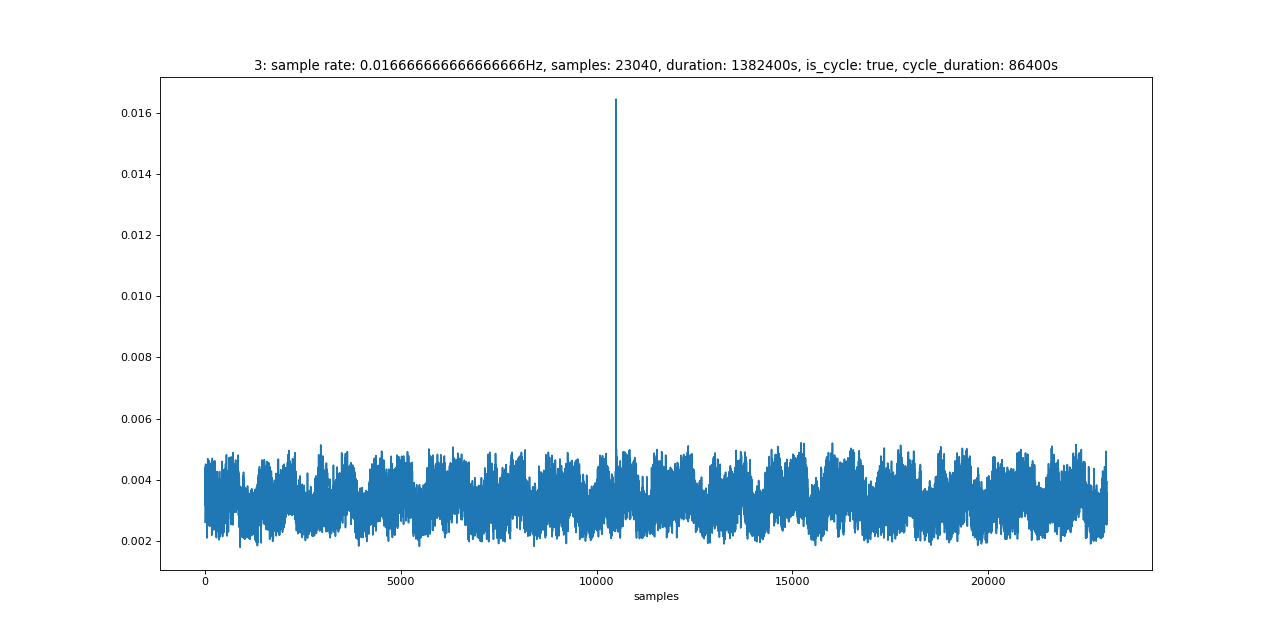

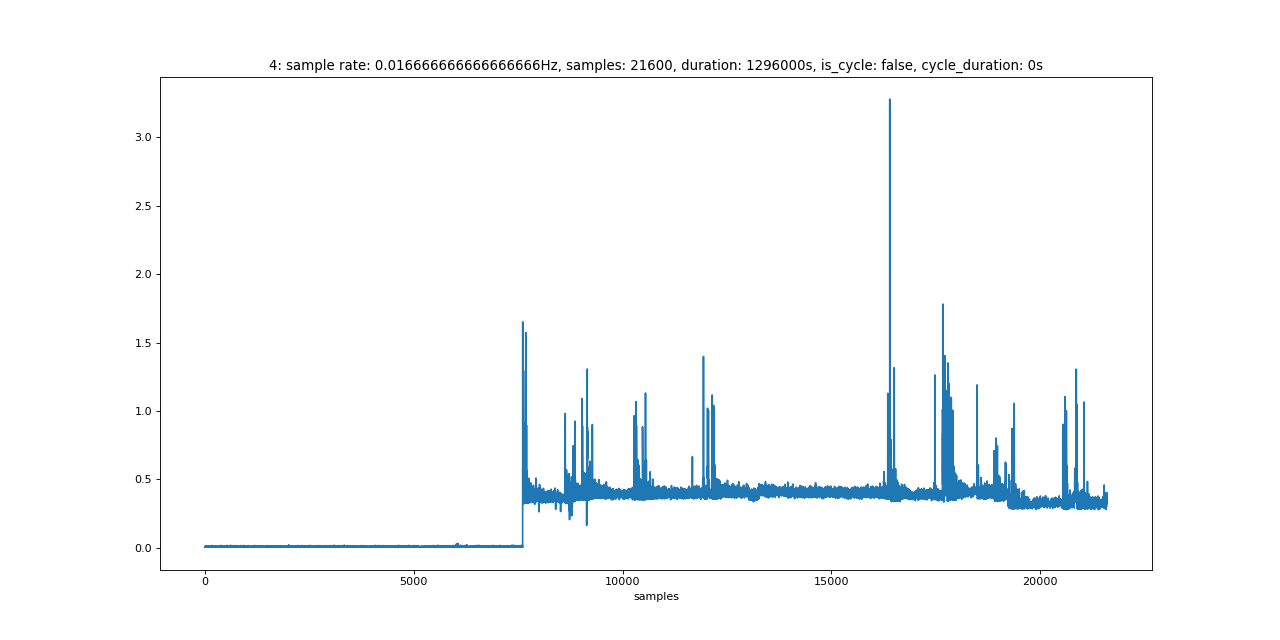

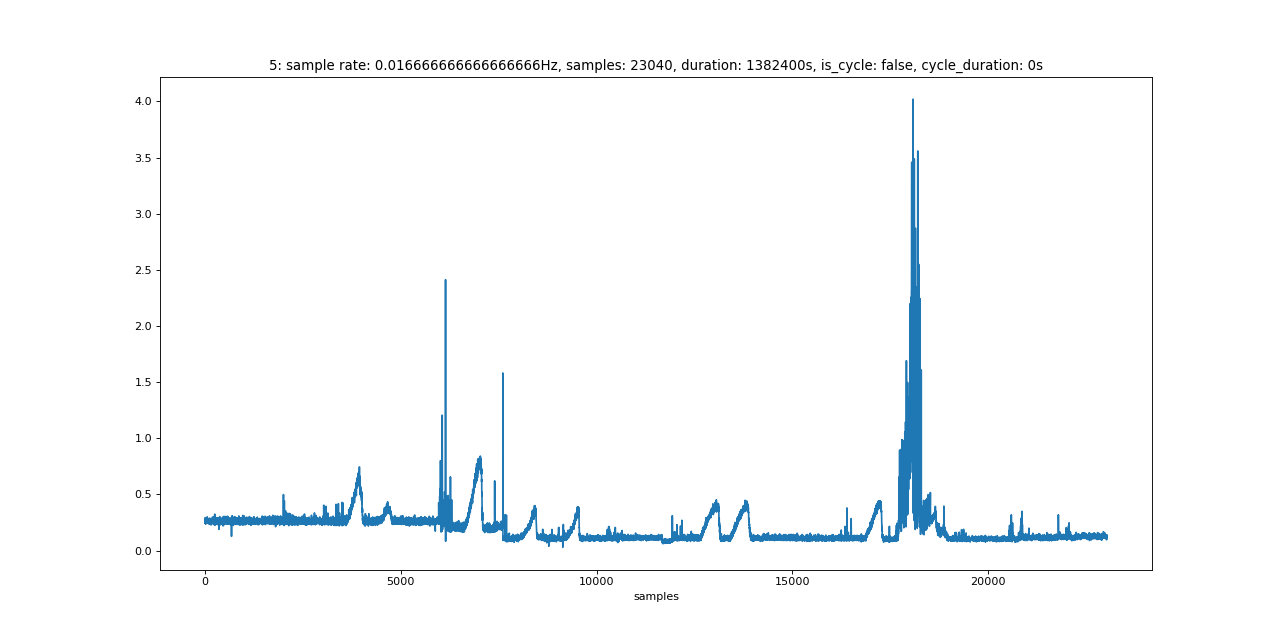

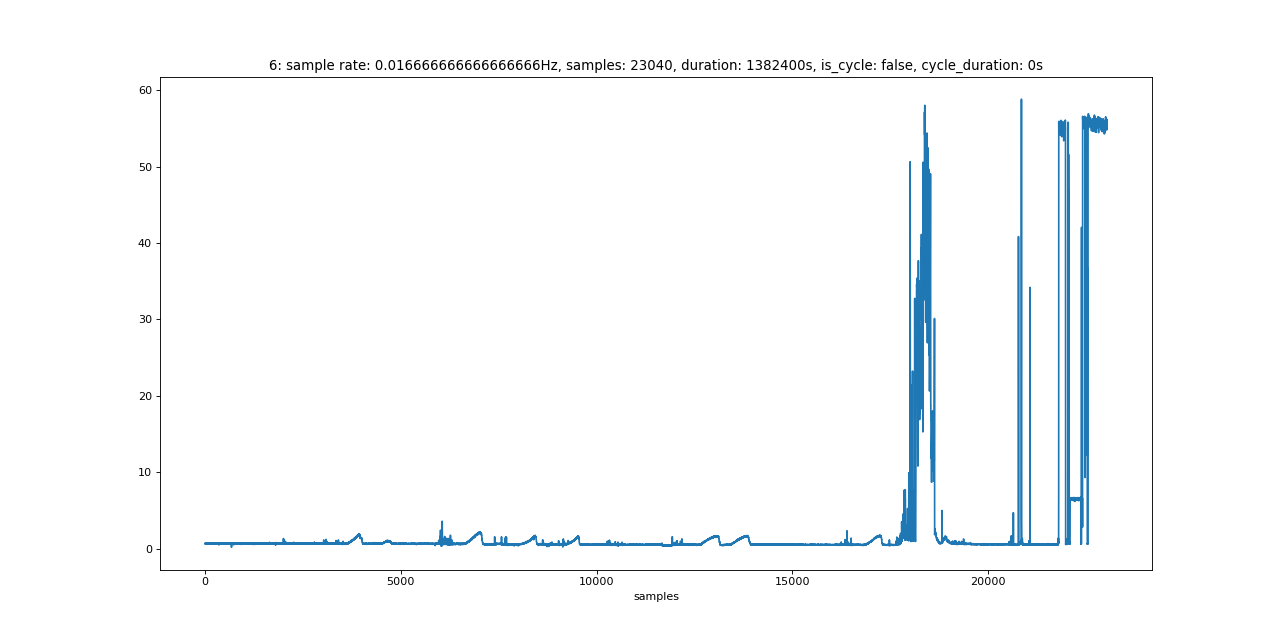

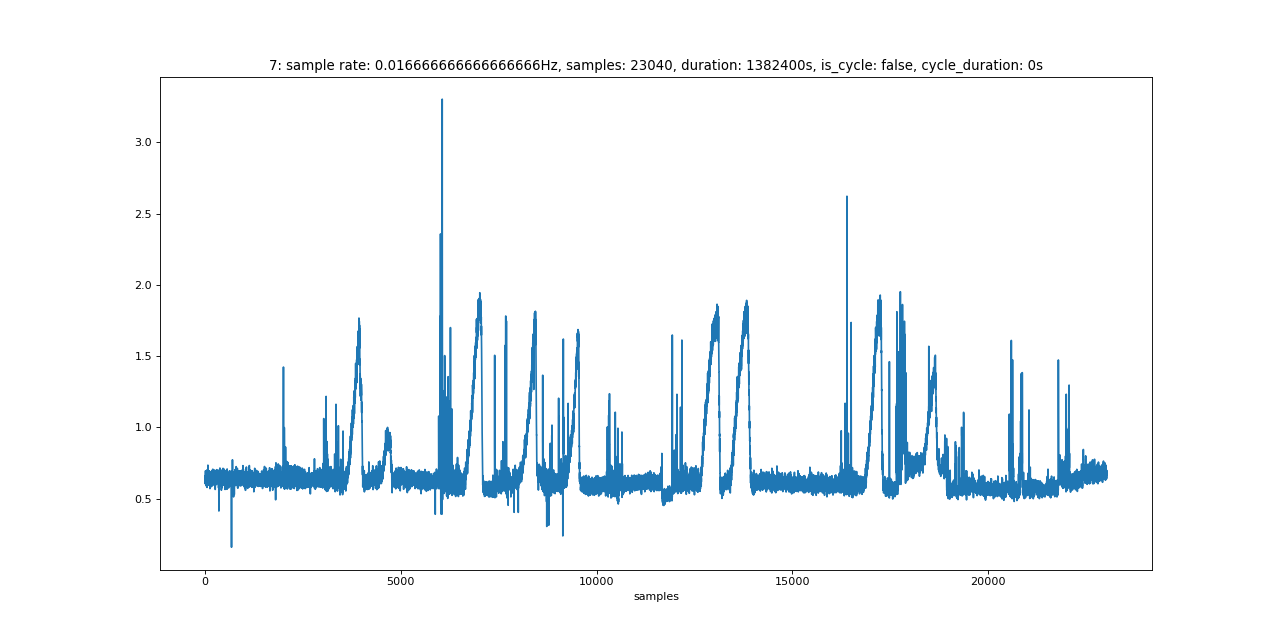

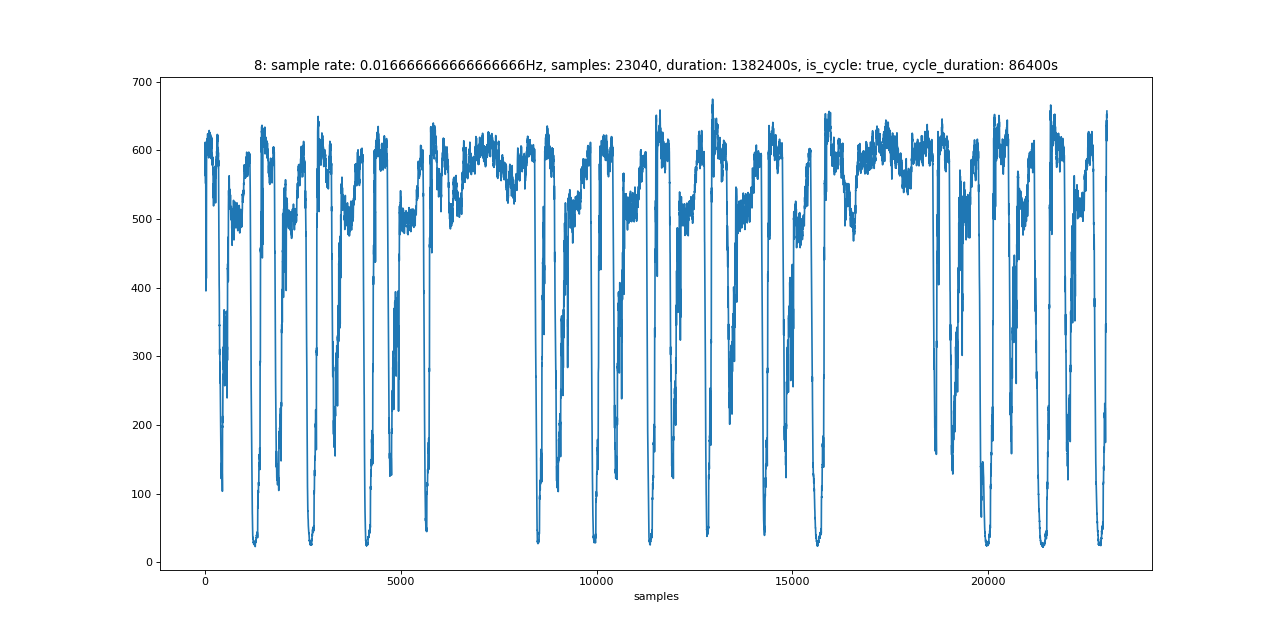

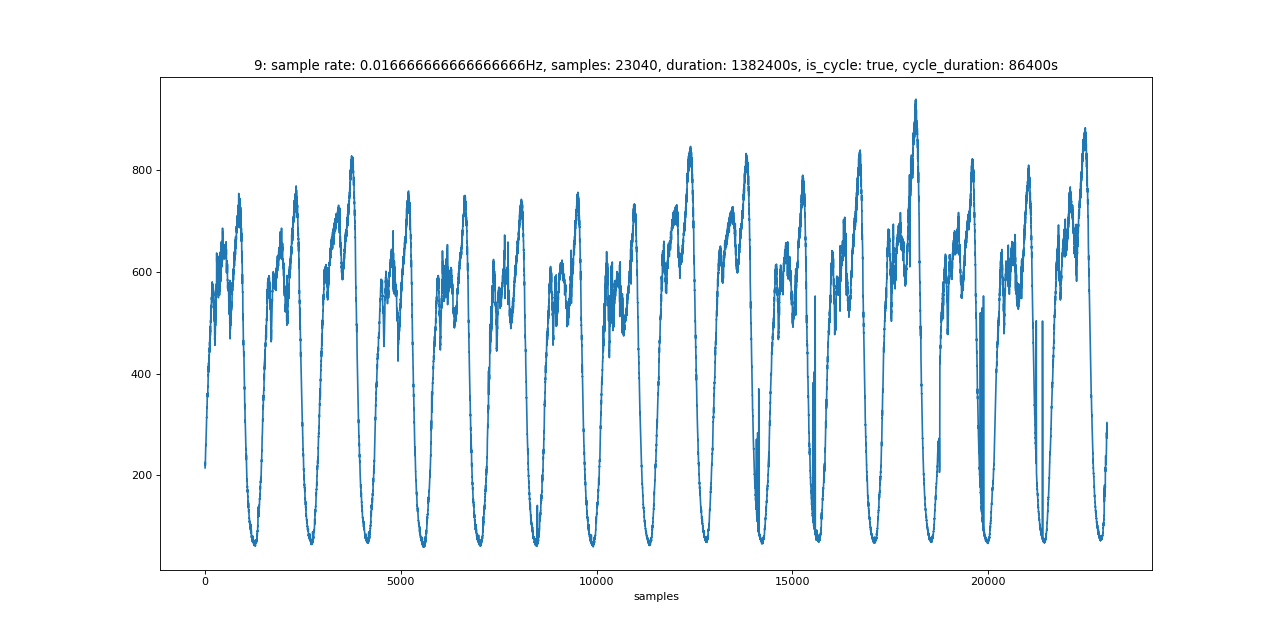

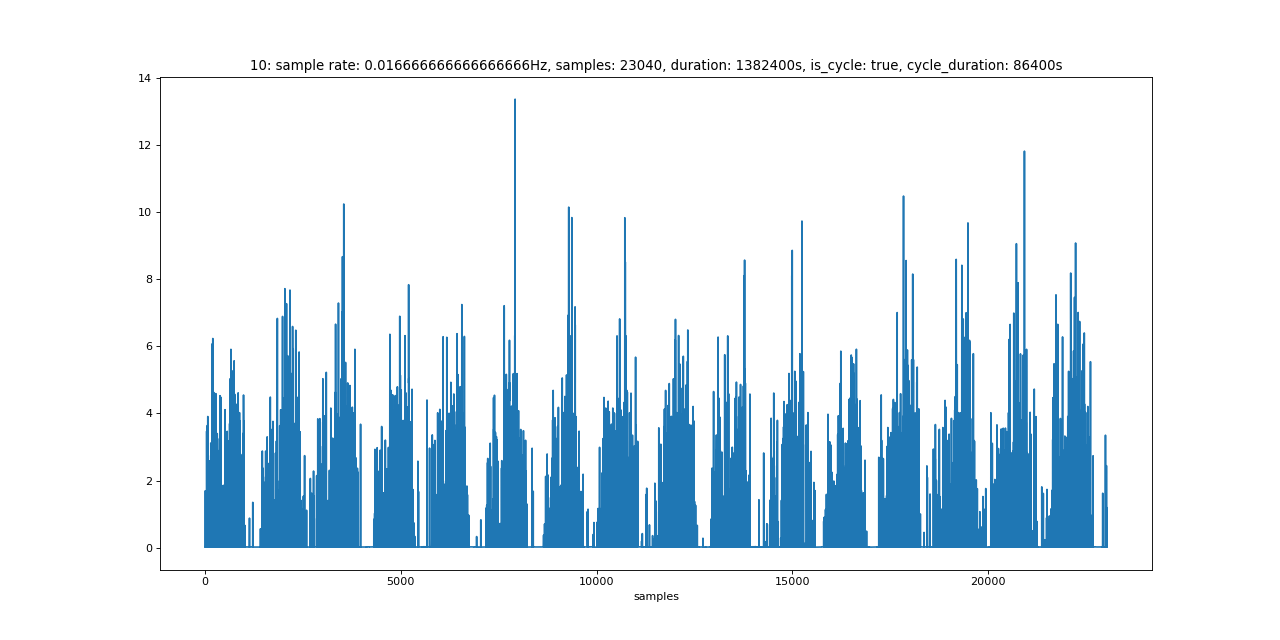

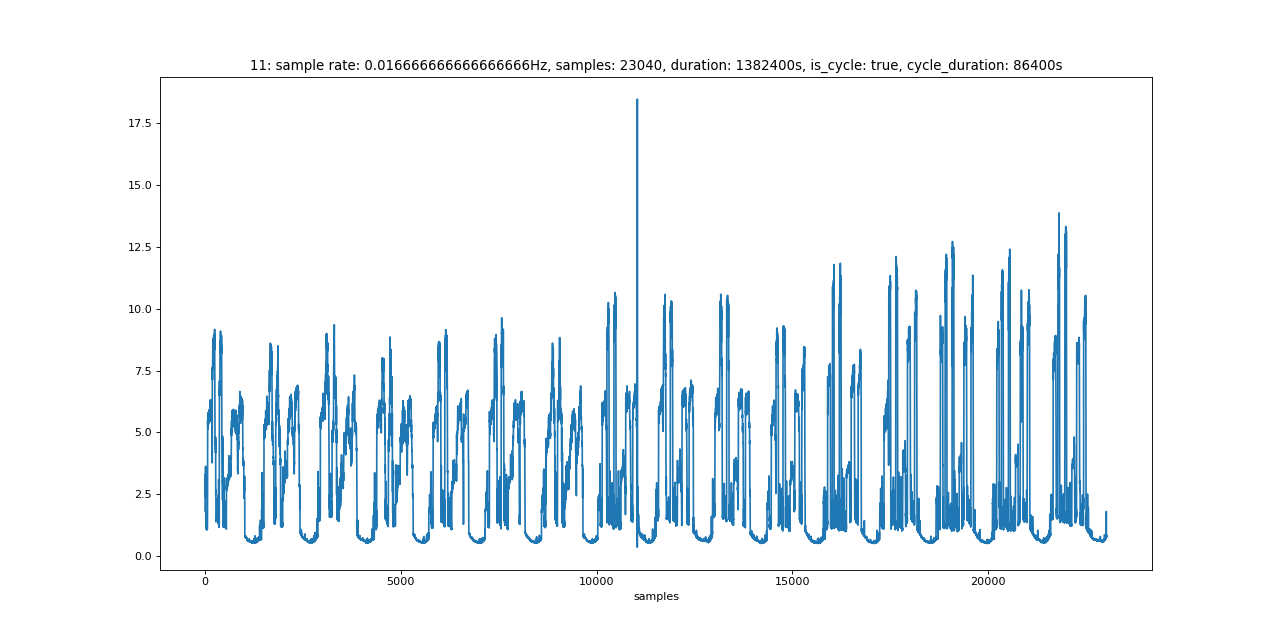

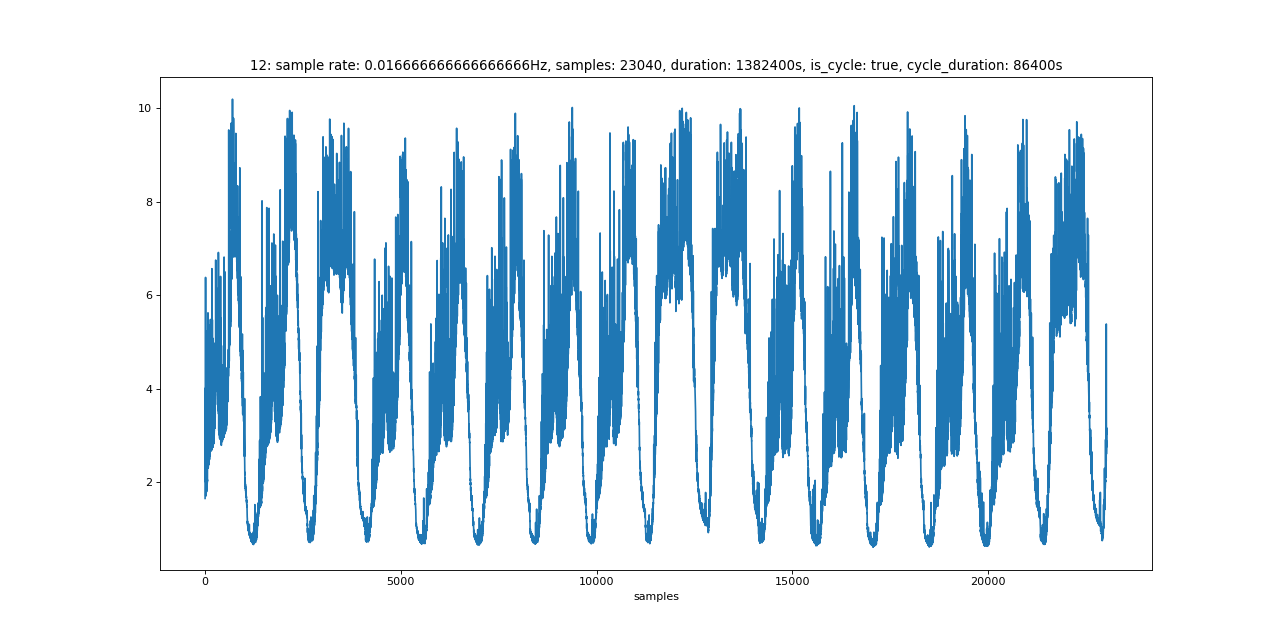

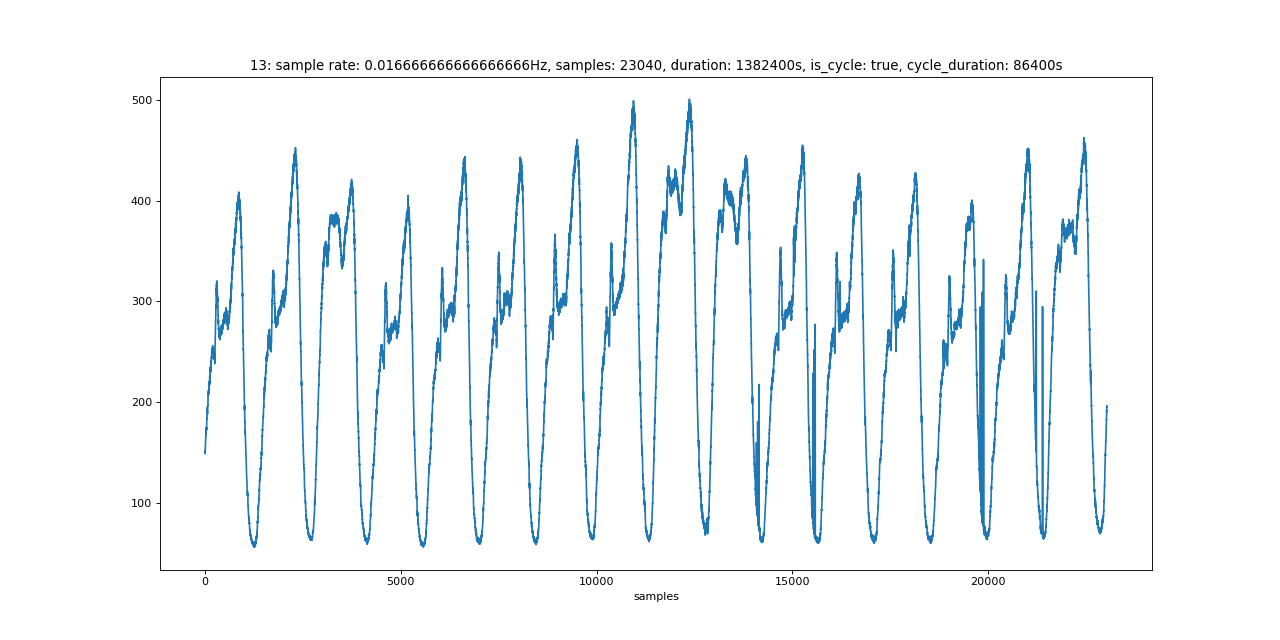

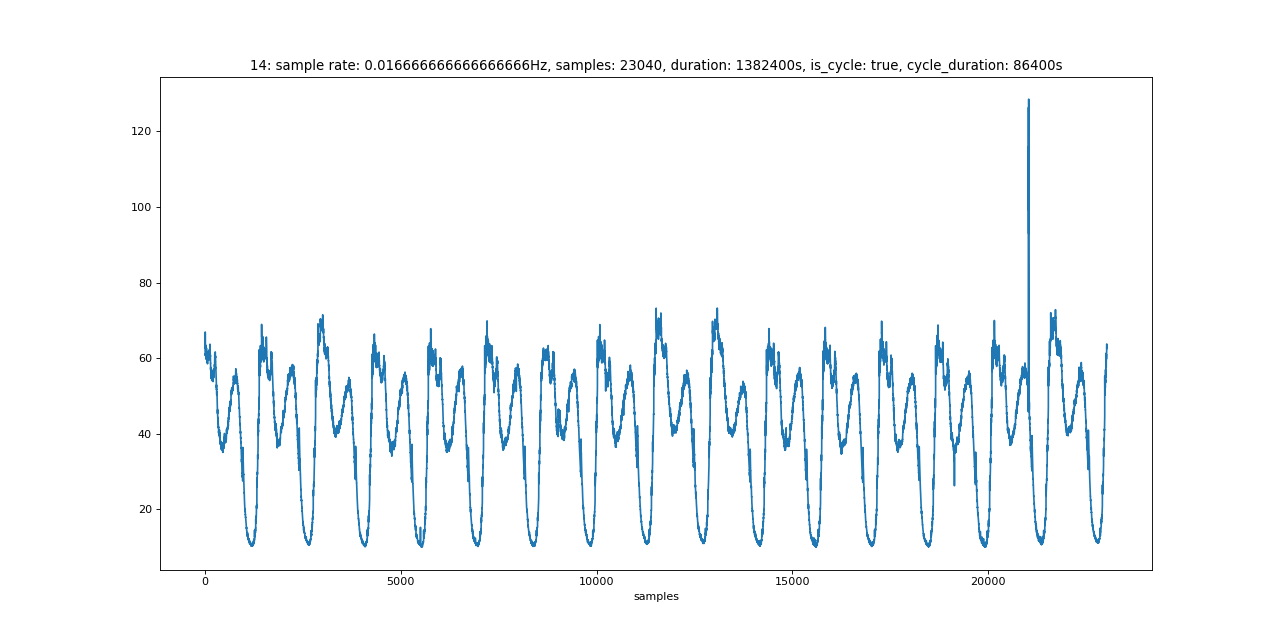

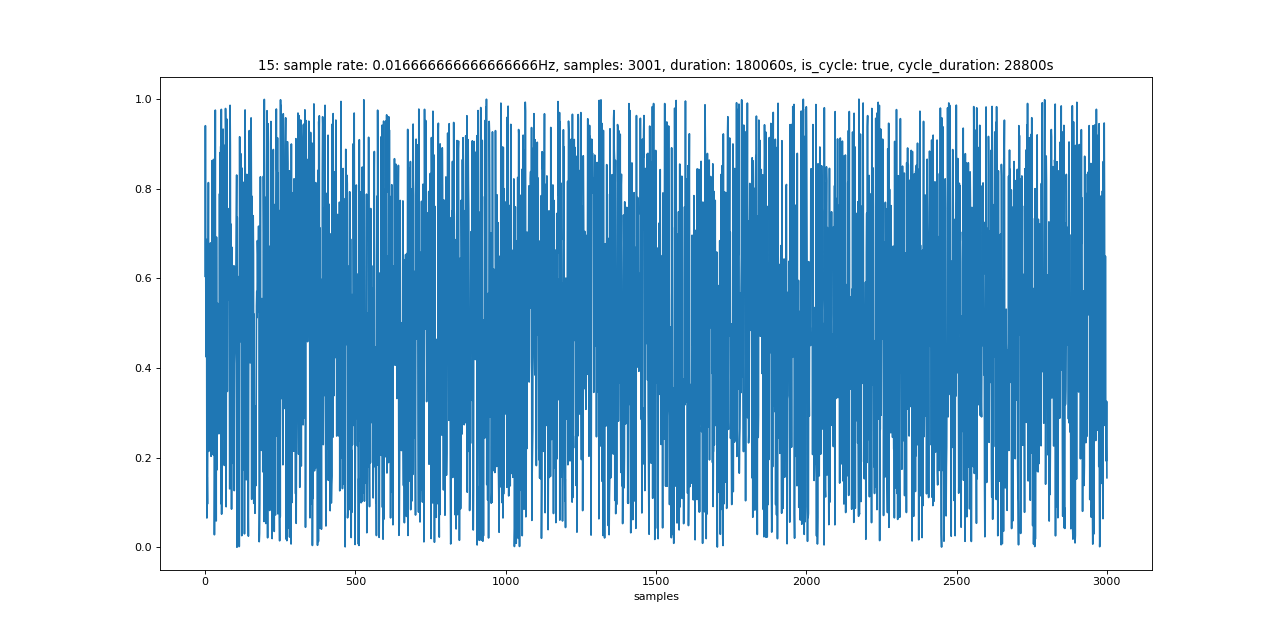

In [9]:
# compare with crane test case, to validate the algorithm is right.
# 1. read crane test csv
sample_rate = 1.0/60
samples_crane_test_data = []
for i in range(len(signal_cycle_labels)):
    sample, sample_df = load_csv_data('./crane_test_data/input{}.csv'.format(i))
    samples_crane_test_data.append(sample_df)
    x = np.arange(len(sample))
    signal_cycle_label = signal_cycle_labels.iloc[i]
    plt.figure(figsize=(16, 8), dpi=80)
    # ax = plt.subplot(i+1,1,1)
    plt.title("{}: sample rate: {}Hz, samples: {}, duration: {}s, is_cycle: {}, cycle_duration: {}s".format(i,sample_rate, len(sample),len(sample)*60,signal_cycle_label["is_cycle"],signal_cycle_label["cycle_duration"]))
    plt.xlabel("samples")
    plt.plot(x, sample[:]['value'])
    plt.show()

In [82]:
# validate same result of is_periodicity
result_crane_test = pd.DataFrame

# label by myself.
is_cycle_expected = [True,True,True,True,False,
                  False,False,False,True,True,
                  True,True,True,True,True,True]
cycle_duration_expected=[60*1440,60*1440,60*1440,60*1440,60*1440,60*1440,60*1440,60*1440,60*10080,60*1440,60*1440,60*1440,60*1440,60*1440,60*1440,60*1440]

cycle_result = []
is_cycles = []
for i in range(len(samples_crane_test_data)):
    data = samples_crane_test_data[i][:]['value'].to_numpy()
    sample_interval = 60
    cycle_duration = cycle_duration_expected[i]
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    cycle_result.append(cycles)
    is_cycles.append(is_cycle)
    
for i in range(len(cycle_result)):
    if is_cycles[i] != is_cycle_expected[i]: print("diff from crane index {}".format(i))
    print(cycle_result[i])

[86400.0]
[86400.0]
[43200.0]
[43200.0]
[]
[]
[]
[]
[43200.0]
[86400.0]
[86400.0]
[43200.0]
[86400.0]
[86400.0]
[43200.0]
[28800.0]


## 2.2 fft 分类算法评估 - tke-x dataset

In [84]:
is_cycle_expected=np.concatenate((cpu_label_data_20220418_20220502_0a9obzx3['is_cycle'].values,cpu_label_data_20220425_20220509_4g9b5b18['is_cycle'].values))

cycle_result=[]
is_cycles=[]
# warn: sequence
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    sample_interval = 30
    cycle_duration = 7*24*60*60
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    cycle_result.append(cycles)
    if is_cycle:
        is_cycles.append(1)
    else:
        is_cycles.append(0)
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    sample_interval = 30
    cycle_duration = 7*24*60*60
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    cycle_result.append(cycles)
    if is_cycle:
        is_cycles.append(1)
    else:
        is_cycles.append(0)

In [85]:
assert len(is_cycles)==len(is_cycle_expected)
print(len(is_cycle_expected))

92


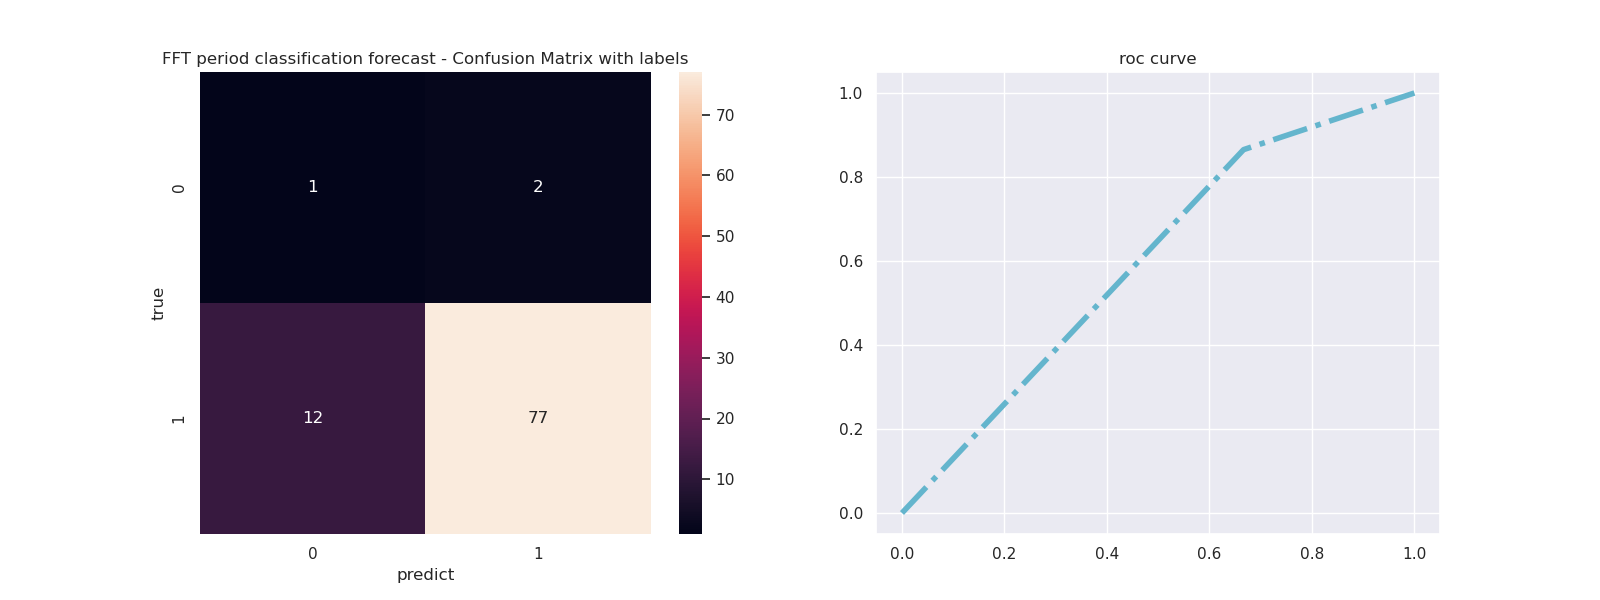

,metrics_name,score
0,accuracy_score,0.847826
1,precision_score,0.945409
2,recall_score,0.847826
3,f1-score,0.890851
4,Missing detection rate,0.134831
5,roc-auc-score,0.599251


In [86]:
# estimator for is_cycle algirithm, target is two classification 
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
# 二分类，但是是不均衡数量，average='weighted'
confusion_matrix = confusion_matrix(is_cycle_expected,is_cycles,labels=[0,1])

sns.set()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
sns.heatmap(confusion_matrix,annot=True,ax=ax1)
ax1.set_title('FFT period classification forecast - Confusion Matrix with labels');
ax1.set_xlabel('predict') 
ax1.set_ylabel('true')

tp = confusion_matrix[1][1]
tn = confusion_matrix[0][0]
fp = confusion_matrix[0][1]
fn = confusion_matrix[1][0]

accuracy_score = accuracy_score(is_cycle_expected,is_cycles)
precision_score = precision_score(is_cycle_expected,is_cycles,average='weighted')
recall_score = recall_score(is_cycle_expected,is_cycles,average='weighted')
f1_score = f1_score(is_cycle_expected,is_cycles,average='weighted')
roc_auc_score = roc_auc_score(is_cycle_expected,is_cycles)
cycle_metrics_pd = pd.DataFrame(columns=['metrics_name', 'score'])
cycle_metric_names = ["accuracy_score","precision_score","recall_score","f1-score","Missing detection rate","roc-auc-score"]
cycle_scores = [accuracy_score,precision_score,recall_score,f1_score,fn/(fn+tp),roc_auc_score]
cycle_metrics_pd['metrics_name'] = cycle_metric_names
cycle_metrics_pd['score'] = cycle_scores

fpr, tpr, thres = roc_curve(is_cycle_expected, is_cycles,drop_intermediate=False)
ax2.plot(fpr, tpr, color='c',linewidth='4',linestyle="-.")
ax2.set_title("roc curve")

plt.show()

cycle_metrics_pd

True Positive （真正, TP）被模型预测为正的正样本；可以称作判断为真的正确率

True Negative（真负 , TN）被模型预测为负的负样本 ；可以称作判断为假的正确率

False Positive （假正, FP）被模型预测为正的负样本；可以称作误报率

False Negative（假负 , FN）被模型预测为负的正样本；可以称作漏报率

### Summary
- 预测准确率（周期信号被预测为周期信号+非周期信号被预测为非周期信号/总预测数）为 0.858696
- 精准率（周期信号被预测为周期信号/检测结果为周期信号数）为 0.945924
- 召回率和准确率一样
- f1 值：0.897324
- roc 曲线的 auc 值：0.661049 （注，由于我们是直接由fft获取频率判断是否为周期信号，而非根据阈值判定是否为周期信号，所以 auc 意义不太，仅做参考）

指标显示目前的 fft 周期性预测算法很有效，可以很好的区分信号是否是周期性型号。

但是依然存在优化的空间，例如使用功率谱进行周期性预测，或者调整超参、修改周期判断逻辑等

# 3. fft, max 预测算法-资源规划

In [14]:
'''
Crane v0.3.0 fft and max prediction.
'''

import logging
from scipy.fft import fft, ifft

# default estimator is fft estimator with different parameters
# min_spectrum_items_nums low_amplitude_threshould margin
# 3  1.0  0.01-0.20
# 50 0.05 0.01-0.20

def update_aggregate_signals(data, sample_interval, cycle_duration,last_timestamp,*args):
# no need for double check signal fit double cycle_duration, already check in is_periodicity
    args = args[0]
    sample_rate = 1.0 / sample_interval
    n = int(cycle_duration * sample_rate)
    m = 0
    i = len(data)
    while (i-n >=0):
        i-=n
        m += 1
    data = data[i:]
    if m < 2:
        return None
    sample_per_cycle = int(len(data)/m)
    history = data[:(m-1)*sample_per_cycle]
    actual = data[(m-1)*sample_per_cycle:]
    min_pe = sys.float_info.max
    best_estimator = {}
    for i in range(len(args)):
        estimator = args[i]["estimator"]
        if estimator == "fft":
            estimated = fft_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        elif estimator == "max":
            estimated = max_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        else:
            return None
        
        if not estimated.empty:
            estimated = estimated['sample']
            pe = predict_error(actual,estimated)
            logging.info("Testing estimators ...", "estimator", estimator, "pe", pe)
            if pe < min_pe:
                min_pe = pe
                best_estimator = args[i]
    result = pd.DataFrame(columns=['timestamp', 'sample'])    
    if best_estimator:
        if best_estimator['estimator'] == "fft":
            estimated = fft_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        elif estimator == "max":
            estimated = max_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        next_timestamp = last_timestamp
        cycles = 1
        if cycle_duration == 60*60:
            cycles = 24
        n = len(estimated)
        samples = np.zeros(n*cycles)
        timestamps = np.zeros(n*cycles)
        for c in range(cycles):
            for i in range(n):
                samples[i+c*n] = estimated['sample'][i]
                next_timestamp += sample_interval
                timestamps[i+c*n] = int(next_timestamp)
        
        result['timestamp'] =  timestamps
        result['sample'] = samples
        
    return result

def fft_get_estimator(data,sample_interval,cycle_duration,*args):
    args = args[0]
    sample_rate = 1.0/sample_interval
    # result = pd.DataFrame(columns=['amp', 'freq','sample_rate','sample'])
    result = pd.DataFrame(columns=['sample_rate','sample'])
    fft_y = fft(data)
    sample_length = len(data)
    amps = np.abs(fft_y)/sample_length*2
    # result['freq'] = sample_rate*np.arange(sample_length)/sample_length
    freqs = sample_rate*np.arange(sample_length)/sample_length
    result['sample_rate'] = sample_rate
    max_spectrum_items_nums = args[0]["max_spectrum_items_nums"]
    min_spectrum_items_nums = args[0]["min_spectrum_items_nums"]
    low_amplitude_threshould = args[0]["low_amplitude_threshould"]
    high_frequency_threshold = args[0]["high_frequency_threshold"]
    margin = args[0]["margin"]
    
    # amps = amps[1:int(len(amps)/2)]
    amps[::-1].sort() # reverse sort
    if len(amps) > max_spectrum_items_nums:
        min_amplitude = amps[max_spectrum_items_nums-1]
    else:
        min_amplitude = amps[-1]
    
    if min_amplitude < low_amplitude_threshould :
        min_amplitude = low_amplitude_threshould
        
    if (len(amps) >= min_spectrum_items_nums) & (amps[min_spectrum_items_nums-1]<min_amplitude):
        min_amplitude = amps[min_spectrum_items_nums-1]
    # Filter out the noise, which is of high frequency and low amplitude
    np.where((amps < min_amplitude)&(freqs > high_frequency_threshold),amps,0.0)
    '''
    for i in range(len(amps)):
        # Filter out the noise, which is of high frequency and low amplitude
        if (amps[i] < min_amplitude) & (freqs[i] > high_frequency_threshold):
             amps[i] = 0.0
    '''
    
    ifft_y = ifft(fft_y)
   
    n_samples_per_cycle = int(cycle_duration*sample_rate)
    samples=np.zeros(n_samples_per_cycle)
    for i in np.arange(len(ifft_y) - n_samples_per_cycle,len(ifft_y),1):
        a = np.real(ifft_y[i])
        if a <=0.0:
            a = 0.01
        samples[i+n_samples_per_cycle-len(ifft_y)] = a*(1.0+margin)
    result['sample'] = samples
    return result
    
def max_get_estimator(data,sample_interval,cycle_duration,*args):
    args = args[0]
    margin = args[0]["margin"]
    sample_rate = 1.0/sample_interval
    result = pd.DataFrame(columns=['sample_rate','sample'])
    result['sample_rate'] = sample_rate
    n_samples_per_cycle = int(cycle_duration*sample_rate)
    samples = np.zeros(n_samples_per_cycle)
    n_samples = len(data)
    n_cycles = int(n_samples/n_samples_per_cycle)
    index = 0
    for i in np.arange(n_samples-n_samples_per_cycle,n_samples,1):
        max_value = data[i]
        for j in np.arange(1,n_cycles,1):
            if max_value < data[i-n_samples_per_cycle*j]:
                max_value = data[i-n_samples_per_cycle*j]
        samples[index] = max_value*(1.0+margin)
        index += 1
    
    result['sample'] = samples
    
    return result

# Amplify x (0.0 < x < 1.0). The bigger x the greater the degree of amplification.
# For example, amplify(0.1) = 0.47 (+370%), amplify(0.5) = 3.1 (+520%)
def amplify(x):
    return -math.log(1.0-x)/math.log(1.25)
    
# from sklearn.metrics import mean_absolute_percentage_error 

def mean_absolute_percentage_error(actual, predict):
    if len(actual) != len(predict):
        raise ValueError("actual and predict signal length is not same")
    
    epsilon = 1e-3
    length = len(actual)
    actual = actual[:length]
    predict = predict[:length]
    err = 0.0
    for i in range(length):
        if actual[i] < epsilon:
            print("actual value is almost 0")
            return 0
        err += abs((predict[i] - actual[i]) / actual[i])
    err = err/length
    return err

# mape with experience
def predict_error(actual, predict):
    if len(actual) != len(predict):
        raise ValueError("actual and predict signal length is not same")
    
    epsilon = 1e-3
    length = len(actual)
    actual = actual[:length]
    predict = predict[:length]
    err = 0.0
    for i in range(length):
        if actual[i] < epsilon:
            print("actual value is almost 0")
            return 0
        if predict[i]<actual[i]:
            err += amplify((actual[i] - predict[i]) / actual[i])
        else:
            err += (predict[i] - actual[i]) / actual[i]
    err = err/length
    #err = mean_absolute_percentage_error(actual, predict)
    return err

def mean_squared_error(actual, predict):
    return np.mean((actual - predict) ** 2, dtype=np.float64)

def normalized_root_mse(actual, predict,normalization='euclidean'):
    actual = np.array(actual)
    predict = np.array(predict)
    if normalization == 'euclidean':
        denom = np.sqrt(np.mean((actual * actual)), dtype=np.float64)
    elif normalization == 'min-max':
        denom = actual.max() - actual.min()
    elif normalization == 'mean':
        denom = actual.mean()
    else:
        raise ValueError("Unsupported norm_type")
    return np.sqrt(mean_squared_error(actual, predict)) / denom

In [15]:
def metrics_predict_error(actuals, predicts, trial_names):
    result = pd.DataFrame(columns=["name","metrics name", "value"])
    metrics_names = []
    values = []
    names = []
    for i in range(len(actuals)):
        actual = actuals[i]
        predict = predicts[i]
        normalized_root_mse_euclidean = normalized_root_mse(actual, predict)
        metrics_names.append("normalized_root_mse_euclidean")
        values.append(normalized_root_mse_euclidean)
        names.append(trial_names[i])
        
        normalized_root_mse_min_max = normalized_root_mse(actual, predict,normalization='min-max')
        metrics_names.append("normalized_root_mse_min_max")
        values.append(normalized_root_mse_min_max)
        names.append(trial_names[i])
        
        normalized_root_mse_mean = normalized_root_mse(actual, predict,normalization='mean')
        metrics_names.append("normalized_root_mse_mean")
        values.append(normalized_root_mse_mean)
        names.append(trial_names[i])
        
        mape_crane = predict_error(actual, predict)
        metrics_names.append("mape_crane")
        values.append(mape_crane)
        names.append(trial_names[i])
        
        mape = mean_absolute_percentage_error(actual, predict)
        metrics_names.append("mape")
        values.append(mape)
        names.append(trial_names[i])
    result["name"] = names
    result["metrics name"] = metrics_names
    result["value"] = values
    return result
        

## 3.1 测试集数据-算法验证

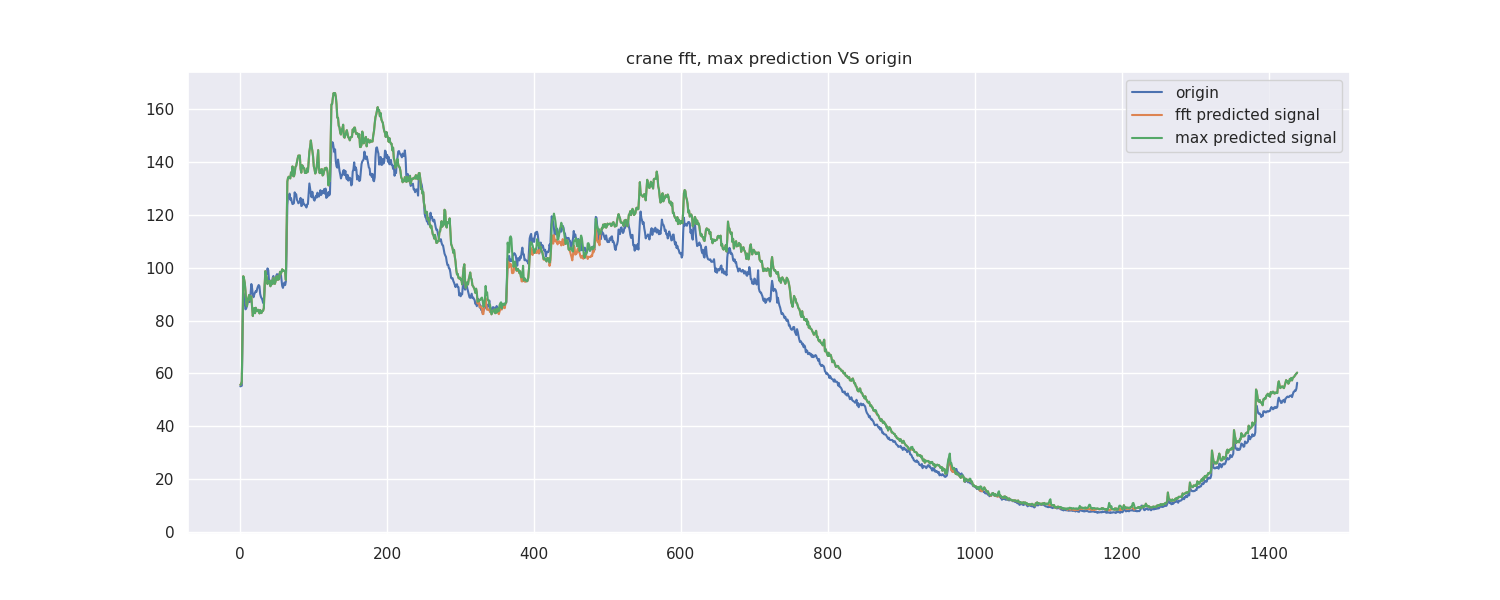

,name,metrics name,value
0,origin-fft,normalized_root_mse_euclidean,0.087177
1,origin-fft,normalized_root_mse_min_max,0.051887
2,origin-fft,normalized_root_mse_mean,0.103858
3,origin-fft,mape_crane,0.104557
4,origin-fft,mape,0.081788
5,origin-max,normalized_root_mse_euclidean,0.086746
6,origin-max,normalized_root_mse_min_max,0.051630
7,origin-max,normalized_root_mse_mean,0.103344
8,origin-max,mape_crane,0.101626
9,origin-max,mape,0.085746


In [42]:
'''
Crane test case for validate the estimator is right.
'''
# cycle_duration、min_spectrum_items_nums、max_spectrum_items_nums、high_frequency_threshold、low_amplitude_threshould、margin、estimator
fft_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.1,"estimator": "fft"}]
max_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.1,"estimator": "max"}]
sample_interval = 60 # 60s collect one point
sample_rate = 1.0/sample_interval
cycle_duration = 24*60*60
csv0 = samples_crane_test_data[0][:]['value']
csv0_one_day = csv0[1440*7:]
csv0_origin = csv0[:1440*7]
is_cycle, cycles = is_periodicity(csv0_origin.to_numpy(), sample_interval, cycle_duration,show_pic=False)
# print(cycles)
# assert int(cycles[0])==24*60*60
fft_predict = fft_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,fft_estimators)
max_predict = max_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,max_estimators)

actuals = []
predicts = []
names=[]

actuals.append(csv0_one_day.to_list())
predicts.append(fft_predict['sample'].to_list())
names.append("origin-fft")

actuals.append(csv0_one_day.to_list())
predicts.append(max_predict['sample'].to_list())
names.append("origin-max")

metrics_predict_errors = metrics_predict_error(actuals,predicts,names)

fig, ax = plt.subplots(figsize=(15,6))
x = np.arange(len(csv0_one_day))
ax.plot(x,csv0_one_day , label='origin')
ax.plot(x, fft_predict['sample'].to_list(), label='fft predicted signal') 
ax.plot(x, max_predict['sample'].to_list(), label='max predicted signal')
ax.legend()
ax.set_title("crane fft, max prediction VS origin")
plt.show()
metrics_predict_errors

这里采用 NRMSE(正规化方均根差) 主要和 mape 以及 mape crane 做对比

## 3.2 算法评估 tke-x dataset

In [44]:
# validation or estimate for fft and max prediction error.
# 评估”fft 预测算法“、”max 预测算法“算法有效性
# cycle_duration、min_spectrum_items_nums、max_spectrum_items_nums、high_frequency_threshold、low_amplitude_threshould、margin、estimator
fft_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.1,"estimator": "fft"}]
max_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.1,"estimator": "max"}]
sample_interval = 30
sample_rate = 1.0/sample_interval
cycle_duration = 7*24*60*60

# warn: sequence
metrics_predict_errors=[]
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    if not is_cycle:
        continue
    index = int(cycle_duration*sample_rate)
    data_origin = data[:index]
    fft_predict = fft_get_estimator(data_origin, sample_interval, cycle_duration,fft_estimators)
    max_predict = max_get_estimator(data_origin, sample_interval, cycle_duration,max_estimators)
    actuals = []
    predicts = []
    names=[]
    length = min(len(fft_predict), len(max_predict))
    data_origin_cycle = data[index:index+length]
    
    
    actuals.append(data_origin_cycle)
    predicts.append(fft_predict['sample'].to_list())
    names.append("origin-fft")

    actuals.append(data_origin_cycle)
    predicts.append(max_predict['sample'].to_list())
    names.append("origin-max")

    mpe = metrics_predict_error(actuals,predicts,names)
    metrics_predict_errors.append(mpe)
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    if not is_cycle:
        continue
    index = int(cycle_duration*sample_rate)
    data_origin = data[:index]
    fft_predict = fft_get_estimator(data_origin, sample_interval, cycle_duration,fft_estimators)
    max_predict = max_get_estimator(data_origin, sample_interval, cycle_duration,max_estimators)
    actuals = []
    predicts = []
    names=[]
    length = min(len(fft_predict), len(max_predict))
    data_origin_cycle = data[index:index+length]
    
    
    actuals.append(data_origin_cycle)
    predicts.append(fft_predict['sample'].to_list())
    names.append("origin-fft")

    actuals.append(data_origin_cycle)
    predicts.append(max_predict['sample'].to_list())
    names.append("origin-max")
    
    mpe = metrics_predict_error(actuals,predicts,names)
    metrics_predict_errors.append(mpe)

actual value is almost 0
actual value is almost 0
actual value is almost 0
actual value is almost 0


In [45]:
metrics_predict_errors = np.array(metrics_predict_errors)

In [46]:
# origin-fft normalized_root_mse_euclidean
def get_percentile(datas):
    p99=[]
    p95=[]
    p50=[]
    mean=[]
    
    for data in datas:
        mean.append(data.mean()) 
        p99.append(np.percentile(data, 99))
        p95.append(np.percentile(data, 95))
        p50.append(np.percentile(data, 50))
    return  p99,p95,p50,mean

a = metrics_predict_errors[:,0,2] # all origin-fft normalized_root_mse_euclidean
b = metrics_predict_errors[:,1,2] # all origin-fft normalized_root_mse_min_max
c = metrics_predict_errors[:,2,2] # all origin-fft normalized_root_mse_mean
d = metrics_predict_errors[:,3,2] # all origin-fft mape_crane
e = metrics_predict_errors[:,4,2] # all origin-fft mape
f = metrics_predict_errors[:,5,2] # all origin-max normalized_root_mse_mean
g = metrics_predict_errors[:,6,2] # all origin-max normalized_root_mse_min_max
h = metrics_predict_errors[:,7,2] # all origin-max normalized_root_mse_mean
j = metrics_predict_errors[:,8,2] # all origin-max mape_crane
k = metrics_predict_errors[:,9,2] # all origin-max mape

datas = [a,b,c,d,e,f,g,h,j,k]

estimated_result = pd.DataFrame(columns=["name","metrics name", "p99","p95","p50","mean"])

names=["origin-fft","origin-fft","origin-fft","origin-fft","origin-fft","origin-max","origin-max","origin-max","origin-max","origin-max"]
metrics_names=["normalized_root_mse_euclidean","normalized_root_mse_min_max","normalized_root_mse_mean","mape_crane","mape","normalized_root_mse_euclidean","normalized_root_mse_min_max","normalized_root_mse_mean","mape_crane","mape"]

p99,p95,p50,mean=get_percentile(datas)

estimated_result["name"]=names
estimated_result["metrics name"]=metrics_names
estimated_result["p99"]=p99
estimated_result["p95"]=p95
estimated_result["p50"]=p50
estimated_result["mean"]=mean

estimated_result.loc[estimated_result['metrics name']=='normalized_root_mse_euclidean']

,name,metrics name,p99,p95,p50,mean
0,origin-fft,normalized_root_mse_euclidean,1.324825,1.234056,0.290701,0.371331
5,origin-max,normalized_root_mse_euclidean,1.324825,1.234056,0.290701,0.371331


这里的 mape_crane 指标显示对于 tke-x 上的 cpu 序列进行周期性预测出的值，max 算法要优于 fft 算法

# 4. vpa cpu/memory 推荐 - percentile 算法

In [20]:
# crane vpa percentile algorithm

from typing import Dict,Type,Any
import collections
class HistogramOptions(object):
    def __init__(self):
        pass
    def num_bucket(self) -> int:
        pass
    def find_bucket(self, value: float) -> int:
        pass
    def get_bucket_start(self, bucket: int) -> float:
        pass
    def get_epsilon(self) -> float:
        pass
# 线性直方图
class LinearHistogramOptions(HistogramOptions):
    def __init__(self, num_buckets: int, bucket_size: float, epsilon: float):
        self.num_buckets = num_buckets
        self.bucket_size = bucket_size
        self.epsilon = epsilon
    def num_bucket(self) -> int:
        return self.num_buckets
    def find_bucket(self, value: float) -> int:
        bucket = int(value/self.bucket_size)
        if bucket < 0:
            return 0
        if bucket > self.num_buckets:
            return num_buckets -1
        return bucket
    def get_bucket_start(self, bucket: int) -> float:
        if bucket <0 | bucket >= self.num_buckets:
            raise ValueError("index out of range")
        return float(bucket) * self.bucket_size
        
    def get_epsilon(self) -> float:
        return self.epsilon

import math
# 衰减直方图，指数桶
class ExponentialHistogramOptions(HistogramOptions):
    def __init__(self, num_buckets: int, first_bucket_size: float,ratio: float, epsilon: float):
        self.num_buckets = num_buckets
        self.first_bucket_size = first_bucket_size
        self.ratio = ratio
        self.epsilon = epsilon
    def num_bucket(self) -> int:
        return self.num_buckets
    def find_bucket(self, value: float) -> int:
        if value < self.first_bucket_size:
            return 0
        
        bucket = int(math.log(value*(self.ratio-1)/self.first_bucket_size+1,self.ratio))
        if bucket > self.num_buckets:
            return num_buckets -1
        return bucket
    def get_bucket_start(self, bucket: int) -> float:
        if bucket <0 | bucket >= self.num_buckets:
            raise ValueError("index out of range")
        if bucket == 0:
            return 0.0
        return self.first_bucket_size * math.pow(self.ratio, float(bucket))
        
    def get_epsilon(self) -> float:
        return self.epsilon
    
class Histogram:
    """
    Histogram represents an approximate distribution of some variable.
    https:#github.com/kubernetes/autoscaler/blob/master/vertical-pod-autoscaler/pkg/recommender/util/histogram.go
    """
    bucket_weights: Dict[int, float]
    total_weight: float
    def __init__(self, total_weight: float,min_bucket: int,max_bucket: int, histogram_options: Type[HistogramOptions]):
        self.bucket_weights = collections.defaultdict(float)
        self.total_weight = total_weight
        self.min_bucket = min_bucket
        self.max_bucket = max_bucket
        self.options = histogram_options
    def add_sample(self, value: float, weight: float, time: float):
        if weight < 0.0:
            raise ValueError("sample weight must be non-negative")
        bucket = self.options.find_bucket(value)
        self.bucket_weights[bucket] += weight
        self.total_weight += weight
        if (bucket < self.min_bucket) & (self.bucket_weights[bucket] >= self.options.get_epsilon()):
            self.min_bucket = bucket
        if (bucket > self.max_bucket) & (self.bucket_weights[bucket] >= self.options.get_epsilon()):
            self.max_bucket = bucket
        return
    def safe_subtract(self, value: float, sub: float, epsilon: float) -> float:
        value -= sub
        if value < epsilon:
            return 0.0
        return value
    def subtract_sample(self, value: float, weight: float, time: float):
        if weight < 0.0:
            raise ValueError("sample weight must be non-negative")
        bucket = self.options.FindBucket(value)
        epsilon = self.options.get_epsilon()
        self.total_weight = safe_subtract(self.total_weight,weight,epsilon)
        self.bucket_weights[bucket] = safe_subtract(self.bucket_weights[bucket],weight,epsilon)
        self.update_min_and_max_bucket()
        return
    
    def merge(self, other: 'Histogram'):
        o = self.__class__(other)
        if self.options != o.options:
            raise ValueError("can't merge histograms with different options")
        for bucket in np.arange(o.min_bucket,o.max_bucket,1):
            self.bucket_weights[bucket] += o.bucket_weights[bucket]
        
        self.total_weight += o.total_weight
        if o.min_bucket < self.min_bucket :
            self.min_bucket = o.min_bucket
        if o.max_bucket > self.max_bucket:
            self.max_bucket = o.max_bucket
        return
    def scale(self, factor: float):
        if factor < 0.0:
            raise ValueError("scale factor must be non-negative")
        for i, v in self.bucket_weights.items():
            self.bucket_weights[i] = v * factor
        self.total_weight *= factor
        self.update_min_and_max_bucket()
    def update_min_and_max_bucket(self):
        epsilon = self.options.get_epsilon()
        last_bucket = self.options.num_bucket() -1 
        while (self.bucket_weights[self.min_bucket] < epsilon & self.min_bucket < last_bucket):
            self.min_bucket += 1
        while (self.bucket_weights[self.max_bucket] < epsilon & self.max_bucket > 0):
            self.min_bucket -= 1
    def percentile(self, percentile: float) -> float:
        if self.is_empty():
            return 0.0
        partial_sum = 0.0
        threshold = percentile * self.total_weight
        bucket = self.min_bucket
        for i, w in sorted(self.bucket_weights.items()):
            partial_sum += w
            if partial_sum >= threshold:
                bucket = i
                break
        if bucket < self.options.num_bucket() -1:
            # last bucket
            return self.options.get_bucket_start(bucket+1)
        # Return the end of the bucket.
        return self.options.get_bucket_start(bucket)
    def is_empty(self) -> bool:
        return (
            self.bucket_weights[self.min_bucket] < self.options.get_epsilon()
        )
    def string(self):
        lines = ["minBucket: %d, maxBucket: %d, totalWeight: %.3f".format(self.min_bucket,self.max_bucket,self.total_weight),"%-tile\tvalue"]
        for i in np.arange(0,100,5):
            lines.append("%d\t%.3f".format(i, self.percentile(0.01*float(i))))
        return "\n".join(lines)
    def equal(self, other: 'Histogram'):
        pass
    def get_checkpoint(self) -> Dict[str, Any]:
        return {
            "total_weight": self.total_weight,
            "bucket_weights": {
                b: w for b, w in self.bucket_weights.items() if w > self.options.get_epsilon()
            }
        }
    def from_checkpoint(self, checkpoint: Dict[str, Any]):
        total_weight = checkpoint["total_weight"]
        if total_weight < 0.0:
            raise ValueError(
                f"Invalid checkpoint data with negative weight {total_weight}"
            )
        for bucket_str, weight in checkpoint["bucket_weights"].items():
            # JSON keys are always strings, convert to int
            bucket = int(bucket_str)
            self.bucket_weights[bucket] += weight
        self.total_weight += total_weight

'''
直方图赋予新样本比旧样本更高的权重，逐渐衰减（“忘记”）过去的样本。 
每个样本的权重乘以因子 2^((sampleTime - referenceTimestamp) / halfLife)。
这意味着信号在每个半衰期都会失去一半的权重（“重要性”）
由于只有样本的相对（而非绝对）权重很重要，因此 referenceTimestamp 可以随时移动，这相当于将所有权重乘以一个常数。
在实践中，只要指数变得太大，referenceTimestamp 就会向前移动，以避免浮点算术溢出。
'''
MAX_DECAY_EXPONENT = 100
class DecayingHistogram(Histogram):
    def __init__(self, half_life: float,total_weight: float,min_bucket: int,max_bucket: int, histogram_options: Type[HistogramOptions]):
        super().__init__(total_weight,min_bucket,max_bucket, histogram_options)
        self.half_life = half_life
        self.reference_time = 0
    def percentile(self, percentile: float):
        return super().percentile(percentile)
    def shift_reference_time(self, new_reference_time: float):
        # Make sure the decay start is an integer multiple of halfLife.
        new_reference_time = int(
            (new_reference_time // self.half_life) * self.half_life
        )
        exponent = round((self.reference_time - new_reference_time) / self.half_life)
        self.scale(2 ** exponent)  # Scale all weights by 2^exponent.
        self.reference_time = new_reference_time
    def decay_factor(self, time: float):
        max_allowed_timestamp = self.reference_time + (self.half_life * MAX_DECAY_EXPONENT)
        if time > max_allowed_time:
            # The exponent has grown too large. Renormalize the histogram by
            # shifting the referenceTimestamp to the current timestamp and rescaling
            # the weights accordingly.
            self.shift_reference_time(time)
        decay_factor = 2 ** ((time - self.reference_time) / self.half_life)
        return decay_factor
    def add_sample(self, value: float, weight: float, time: float):
        super().add_sample(value, weight*self.decay_factor(time), time)
        return
    def subtract_sample(self, value: float, weight: float, time: float):
        super().subtract_sample(value, weight*self.decay_factor(time),time)
        return
    def merge(self, other: 'DecayingHistogram'):
        o = self.__class__(other)
        if self.half_life != o.half_life:
            raise ValueError("can't merge decaying histograms with different half life periods")
        if self.reference_time < o.reference_time:
            self.shift_reference_time(o.reference_time)
        elif o.reference_time < self.reference_time:
            o.shift_reference_time(self.reference_time)
        super().merge(o)
    def is_empty(self) -> bool:
        return super().is_empty()
    def string(self) -> str:
        return "referenceTimestamp: %f, halfLife: %f\n%s".format(self.reference_time,self.half_life,super().string())
    def get_checkpoint(self) -> Dict[str, Any]:
        return {
            "total_weight": self.total_weight,
            "bucket_weights": {
                b: w for b, w in super().bucket_weights.items() if w > super().get_epsilon()
            },
            "reference_time": self.reference_time,
        }
    def from_checkpoint(self, checkpoint: Dict[str, Any]):
        total_weight = checkpoint["total_weight"]
        if total_weight < 0.0:
            raise ValueError(
                f"Invalid checkpoint data with negative weight {total_weight}"
            )
        for bucket_str, weight in checkpoint["bucket_weights"].items():
            # JSON keys are always strings, convert to int
            bucket = int(bucket_str)
            super().bucket_weights[bucket] += weight
        super().total_weight += total_weight
        self.reference_time = checkpoint["reference_time"]

In [21]:
# container request 推荐 cpu 和 memory
# percentile 算法
# crane v0.3.0 percentile 算法 with margin

# recommendation reconcile, period or once, inspector will check you need recommand hpa or resource request, and advisor will give recommandation.
# doRecommend -> recommendation.Offer -> ResourceRequestAdvisor.Advise -> get percentile predictor -> makeCpuConfig/makeMemConfig -> 
# default_cpu(sample_interval=1m,percentile=0.99,margin=0.15,histogram(half_life=24h,bucket_size=0.25,max_value=100))
# default_memory(sample_interval=1m,percentile=0.99,margin=0.15,histogram(half_life=48h,bucket_size=104857600,max_value=104857600000))
# QueryRealtimePredictedValuesOnce -> if no registed signals, we first fetch history data to construct the histogram model, then get estimation. -> process
# makeInternalConfig configure the histogram configuration,for resource request is LinearHistogramOptions
# default configuration for cpu （epsilon:1e-10, max_value: 100, bucket_size: 0.25, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
# default configuration for memory （epsilon:1e-10, max_value: 104857600000,ucket_size: 104857600, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
# create a dry-run proposal, 



# when init controller, will init aggregateSignals in forloop.
# Reconcile TimeSeriesPrediction object
# syncTimeSeriesPrediction -> syncPredictionStatus
    # check if needed(no predict data、end_timestamp of window out of prev predict time range) update prediction status
    # predict double times of PredictionWindowSeconds of spec
    # percentilePrediction.QueryPredictedTimeSeries
        # getPredictedValues 100ms timeout, vpa.Histogram Percentile(e.percentile)*(1+margin)

# set default config of percentile in makeInternalConfig
default_min_sample_weight = 1e-5
        
# 假设 data 是已经存在的 aggregateSignals, 保存的是一组容器聚合信号，作为推荐的输入
# 输出的是指定分布的百分位数
# crane cpu 和 memory 分布默认是线性直方图 ,可选衰减直方图 decaying histograms
# 参考：https://github.com/kubernetes/autoscaler/blob/d509cf0f1a9513e89dae20a69a581ce11ba4c0b0/vertical-pod-autoscaler/pkg/recommender/model/aggregate_container_state.go#L91


# ContainerNameToAggregateStateMap map[container_name]*AggregateContainerState
# samples is same container name in same pod and namespace cpu/memory usage collections
# In crane, named aggragateSignal
def new_aggregate_container_state_cpu(samples):
    '''vpa default
    # num_buckets first_bucket_size ratio epsilon from default vpa config
    # cpu_num_buckets = int(math.ceil(math.log(math.log(1000.0 * (1.0+0.05 - 1) / 0.01 + 1),1.+0.05)) + 1
    # cpu_histogram_options = ExponentialHistogramOptions(cpu_num_buckets,0.01,1.+0.05,0.001*0.1)
    '''
    # In crane will use LinearHistogram, from newAggregateSignal
    # default configuration for cpu （epsilon:1e-10, max_value: 100, bucket_size: 0.25, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
    # num_buckets,bucket_size, epsilon
    cpu_num_buckets = int(math.ceil(100/0.25)) + 1
    cpu_histogram_options = LinearHistogramOptions(cpu_num_buckets,0.25,1e-10)
    
    '''vpa default
    # half_life,total_weight,min_bucket,max_bucket, histogram_options
    # half_life default is 24h
    # aggregate_cpu_usage = DecayingHistogram(24*60*60,0.0,cpu_histogram_options.num_bucket(),0,cpu_histogram_options)
    '''
    # default sample_interval=1m,percentile=0.99,margin=0.15,history length default is 7d for crane, but now sample_interval is 30s,and history length is 1d
    # total_weight ,min_bucket ,max_bucket , histogram_options
    aggregate_cpu_usage = Histogram(0.0,cpu_histogram_options.num_bucket()-1,0,cpu_histogram_options)
    for i in range(len(samples)):
        sample = samples[i]
        # origin vpa will use this,diff from crane
        '''vpa default
        # aggregate_cpu_usage.add_sample(sample['cpu_usage'],max(sample['request'], 0.1),i*30) # sample duration is 30s
        '''
        # value: float, weight: float, time: float):
        aggregate_cpu_usage.add_sample(sample, max(default_min_sample_weight,sample),i)
    return aggregate_cpu_usage
        
    
    
def new_aggregate_container_state_memory(samples):
    '''vpa default
    # num_buckets first_bucket_size ratio epsilon from default vpa config
    memory_num_buckets = int(math.ceil(math.log(math.log(1e12 * (1.0+0.05 - 1) / 1e7 + 1),1.+0.05)) + 1
    memory_historgram_options = ExponentialHistogramOptions(memory_num_buckets, 1e7,1.+0.05,0.001*0.1)
    '''
                          
    # num_buckets,bucket_size, epsilon
    # default configuration for memory （epsilon:1e-10, max_value: 104857600000,bucket_size: 104857600, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
    memory_num_buckets = int(math.ceil(104857600000/104857600)) + 1
    memory_histogram_options = LinearHistogramOptions(memory_num_buckets,104857600,1e-10)
    '''
    # half_life,total_weight,min_bucket,max_bucket, histogram_options
    # half_life default is 24h
    aggregate_memory_peaks = DecayingHistorgam(24*60*60,0.0,memory_histogram_options.num_bucket(),0,memory_histogram_options)
    '''
    # total_weight ,min_bucket ,max_bucket , histogram_options
    aggregate_memory_peaks = Histogram(0.0,memory_histogram_options.num_bucket()-1,0,memory_histogram_options)
    for i in range(len(samples)):
        sample = samples[i]
        # origin vpa will use this,diff from crane
        '''vpa default
        # aggregate_memory_peaks.add_sample(sample['memory_usage'],max(sample['request'], 0.1),i*30) # sample duration is 30s
        '''
        # value: float, weight: float, time: float):
        aggregate_memory_peaks.add_sample(sample, max(default_min_sample_weight,sample),i)
    return aggregate_memory_peaks
    

# container metrics data
# container_name, pod_name, pod_namespace, usage(cpu, memory), time, window.duration
# data is offline container metrics
# AggregateContainerState
def percentile_predict(data, percentile: float,aggregated: bool,predict_type: str,*args):
    default_margin = 0.15
    if predict_type=='cpu':
        aggregate_usage = new_aggregate_container_state_cpu(data)
    elif predict_type == 'memory':
        aggregate_usage = new_aggregate_container_state_memory(data)
    else:
        raise ValueError("type is not supported for predict")
    result = []
    if aggregated:
        value = (1+default_margin)*aggregate_usage.percentile(percentile)
        result.append(value)
    else:
        for sample in data:
            value = (1+default_margin)*aggregate_usage.percentile(percentile)
            result.append(value)
    return result

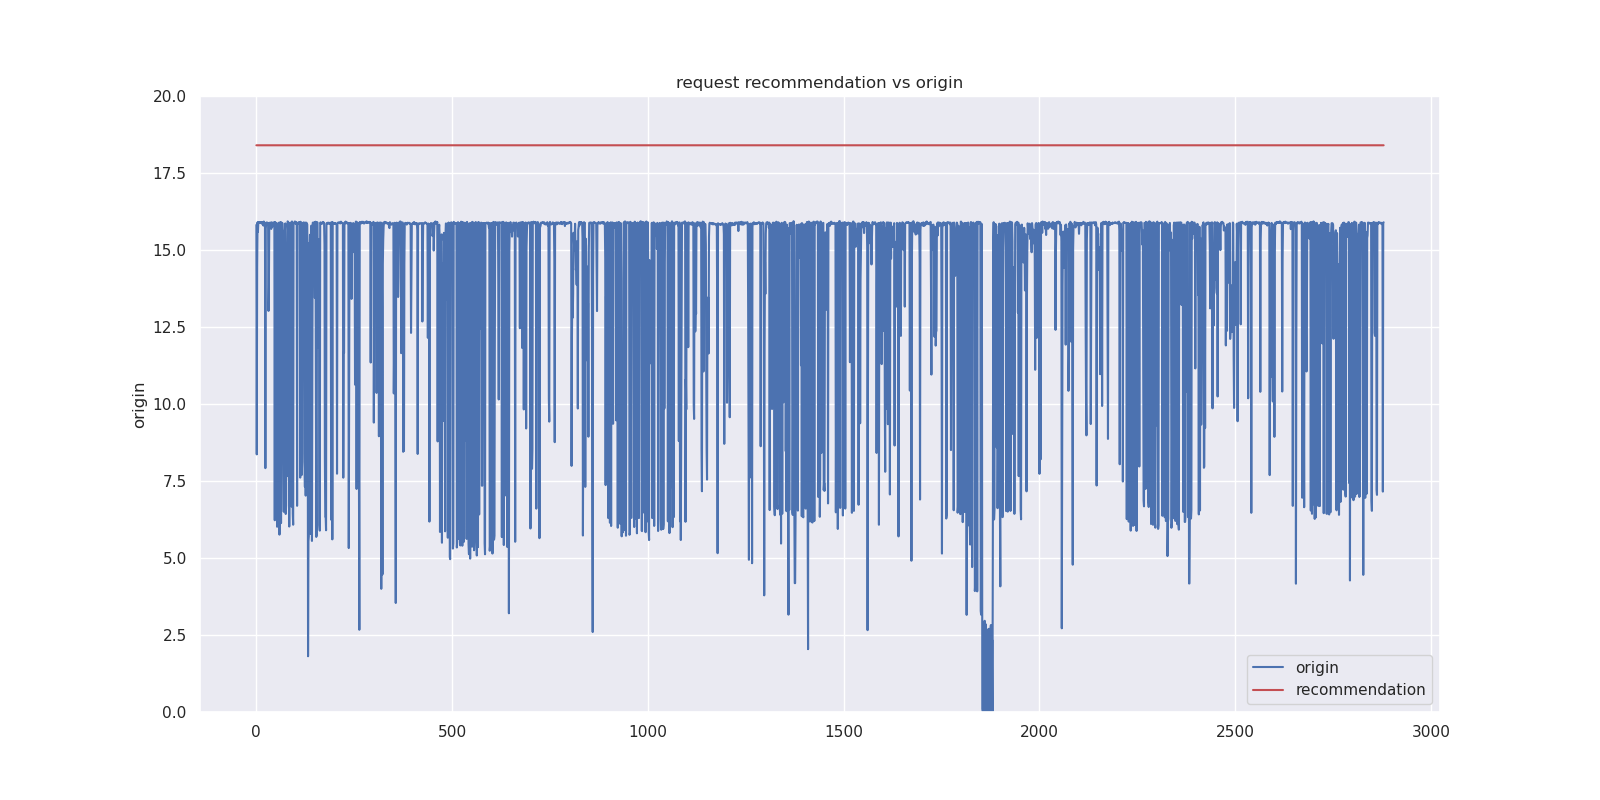

In [22]:
# check cpu request recommendation(one day).
one_day_index = int(24*60*60/30)
data = cpu_data_20220418_20220502_0a9obzx3.iloc[0,1:].values
index = len(data)-one_day_index
data_origin = data[:index]
result = percentile_predict(data_origin, 0.99, True,'cpu')
result

data_last = data[index:]
x = np.arange(len(data_last))
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(111)
ax1.plot(x, data_last,label='origin')
ax1.set_ylabel('origin')
ax1.set_title("request recommendation vs origin")
ax1.set_ylim((0,20))
ax1.plot(x, result*np.ones(len(data_last)), 'r',label='recommendation')
ax1.legend()
plt.show()

In [23]:
def score(recommendation, data):
    bins = 24
    length = len(data)
    score = 0.0
    datas = np.split(data,bins)
    weight = np.arange(1,bins+1,1,dtype=float)
    weight = weight/weight.sum()
    weight = weight[::-1]
    
    for i,data in enumerate(datas):
        score += np.sum((data > recommendation) != 0) * weight[i]
    return score

In [24]:
# one day
scores = []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[:index]
    result = percentile_predict(data_origin, 0.99, True,'cpu')
    s = score(result, data[index:])
    scores.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[:index]
    result = percentile_predict(data_origin, 0.99, True,'cpu')
    s = score(result, data[index:])
    scores.append(s)

In [25]:
# less is good.
print("p99 :",np.percentile(scores, 99))
print("p95 :",np.percentile(scores, 95))
print("p50 :",np.percentile(scores, 50))
print("mean : ",np.mean(scores))

p99 : 0.008400000000000319
p95 : 0.0
p50 : 0.0
mean :  0.0010144927536231885


打分机制：根据后一天的值和预测 request 值比较，如果超过则增加，这里会根据后一天每小时，进行权重打分

从打分结果看，request 推荐的 cpu 值几乎都未超过后一天 cpu 使用量，预测算法很有效

# 5. Summary

# Summary
## 1. fft 周期性分类算法 评估
   ### 1. 目前针对以标记样本进行分类，指标如下：
   ```
    metrics_name    score
    accuracy_score  0.858696
    precision_score 0.945924
    recall_score    0.858696
    f1-score        0.897324
 Missing detection rate 0.123596
    roc-auc-score   0.604869
   ```
- 预测准确率（周期信号被预测为周期信号+非周期信号被预测为非周期信号/总预测数）为 0.858696
- 精准率（周期信号被预测为周期信号/检测结果为周期信号数）为 0.945924
- 召回率和准确率一样
- f1 值：0.897324
- roc 曲线的 auc 值：0.661049 （注，由于我们是直接由fft获取频率判断是否为周期信号，而非根据阈值判定是否为周期信号，所以 auc 意义不太，仅做参考）

指标显示目前的 fft 周期性预测算法很有效，可以很好的区分信号是否是周期性型号。
   ### 2. 思考
   - 依然存在优化的空间，是否是周期信号预测比较准确，但是预测出的主周期不太准确,另外漏检率较高，后期可以考虑优化的点例如使用功率谱进行周期性预测，或者调整超参、修改周期判断逻辑等

## 2. fft, max 周期性预测算法 评估
   ### 1. 目前针对标记样本进行预测，指标如下：
   ```
   name         metrics name   p99       p95        p50         mean
   origin-fft   mape_crane    16.258358 10.829426   0.590909    1.612668
   origin-max   mape_crane    15.120538 10.238221   0.600736    1.571310
    
   ```
   通过对比发现 crane 的 adjust mape 评估指标可以有效的评估预测的准确性
   
   mape_crane 指标显示对于 tke-x 上的 cpu 序列进行周期性预测出的值，max 算法要优于 fft 算法
   ### 思考
   - 这里的周期性预测算法需要根据业务场景进行超参数的调优，目前是网格调优，后期是否可以优化
    
## 3. cpu, memory request (percentile 算法) 评估
   ### 1. 目前针对 cpu， memory request 推荐算法评估
   ```
   p99 : 0.008400000000000319
   p95 : 0.0
   p50 : 0.0
   mean :  0.0010144927536231885
   ```
   打分机制：根据后一天的值和预测 request 值比较，如果超过则增加，这里会根据后一天每小时，进行权重打分
   
   从打分结果看，request 推荐的 cpu 值几乎都未超过后一天 cpu 使用量，预测算法很有效
   
   ### 思考
   - 后续可以实现 vpa 推荐算法，和 crane request 推荐算法做有效性对比，通过离线评估让用户对该算法更有信心
   
## 4. 总结

该评估达到两个目的：
1. 复现目前  crane v0.3.0 的三种主要算法，为后期算法优化提供支撑：
    - 基于 dsp fft 预测周期性
    - 基于 dsp fft, max 算法预测周期信号做资源规划
    - 基于 percentile 实现 request 推荐算法

2. 沉淀离线评估 pipeline，为后期算法有效性评估提供支撑
    - 数据获取 （es + prom python utils）
    - 数据清洗
    - 算法评估指标